<h1>Feather Tutorial</h1>

In [1]:
# from graphviper.dask.client import local_client
# viper_client = local_client(cores=4, memory_limit="4GB")

import dask
dask.config.set(scheduler="synchronous")
# dask.config.set(scheduler="threads")

Read in input images

In [2]:
from xradio.image import read_image
# single dish image
sd_xds = read_image("sd.zarr")
chans_per_chunk = 2**28/(sd_xds.dims["l"]*sd_xds.dims["m"])
chans_per_chunk = min(sd_xds.dims["frequency"], chans_per_chunk)
chunksize = {
    "frequency": chans_per_chunk, "l": sd_xds.dims["l"],
    "m": sd_xds.dims["m"]
}
sd_xds["sky"].chunk(chunksize)

### add multibeam
from xradio.image._util.common import _set_multibeam_array
import dask.array as da
del sd_xds.attrs["beam"]
sky_shape = sd_xds["sky"].shape
beam_shape = sky_shape[:3] + (3,)
beam_ary = da.zeros(beam_shape)
beam_ary[:, :, :, 0:2] = 0.0040724349213201025
sd_xds = _set_multibeam_array(sd_xds, beam_ary, "rad")
###
sd_xds

<xarray.Dataset>
Dimensions:          (l: 1024, m: 1024, polarization: 1, time: 1,
                      frequency: 16, beam_param: 3)
Coordinates:
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 1.1e+07 9.626e+06 ... -9.626e+06
  * frequency        (frequency) float64 1.4e+09 1.407e+09 ... 1.493e+09 1.5e+09
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Data variables:
    sky              (time, polarization, frequency, l, m) float32 dask.array<chunksize=(1, 1, 16, 1024, 1024), meta=np.ndarray>
    beam             (time, polarization, frequency, beam_param) float64 dask.array<chunksize=(1, 1, 16, 3), meta=np.ndarray>
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

In [3]:
# interferometer image
int_xds = read_image("int.zarr")
chunksize = {
    "frequency": chans_per_chunk, "l": sd_xds.dims["l"],
    "m": sd_xds.dims["m"]
}
int_xds["sky"].chunk(chunksize)
int_xds.beam

# add multibeam
from xradio.image._util.common import _set_multibeam_array
import dask.array as da
del int_xds.attrs["beam"]
beam_ary = da.zeros(beam_shape)
beam_ary[:, :, :, 0] = 0.0003175938332518091
beam_ary[:, :, :, 1] = 0.00031237226207452706
beam_ary[:, :, :, 2] = -0.054892581207198074
int_xds = _set_multibeam_array(int_xds, beam_ary, "rad")
###
int_xds


<xarray.Dataset>
Dimensions:          (l: 1024, m: 1024, polarization: 1, time: 1,
                      frequency: 16, beam_param: 3)
Coordinates:
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 1.1e+07 9.626e+06 ... -9.626e+06
  * frequency        (frequency) float64 1.4e+09 1.407e+09 ... 1.493e+09 1.5e+09
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Data variables:
    sky              (time, polarization, frequency, l, m) float32 dask.array<chunksize=(1, 1, 16, 1024, 1024), meta=np.ndarray>
    beam             (time, polarization, frequency, beam_param) float64 dask.array<chunksize=(1, 1, 16, 3), meta=np.ndarray>
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

In [4]:
if sd_xds["sky"].shape != int_xds["sky"].shape:
    raise RuntimeError("Image shapes differ")

In [5]:
from astropy import units as u

def _beam_area_single_beam(xds):
    beam = xds.attrs["beam"]
    bmaj = beam["major"]
    major = u.Quantity(
        f"{bmaj['value']}{bmaj['units']}"
    )
    bmin = beam["minor"]
    minor = u.Quantity(
        f"{bmin['value']}{bmin['units']}"
    )
    area = major * minor
    return area.to(u.rad*u.rad)

    """
    elif "beams" in xds.data_vars:
        # TODO deal when there are multiple beams
        area = xr.DataArray(
            (
                xds.beam.sel(beam_param=["major"]).values
                * xds.beam.sel(beam_param=["minor"]).values
            ).squeeze(3),
            dims=["time", "polarization", "frequency"],
            coords=dict(
                time=xds.time,
                polarization=xds.polarization, 
                frequency=xds.frequency
            )
        )
        bu = u.Unit(xds["beam"].attrs["units"])
        units = bu * bu
        f = units.to(u.rad * u.rad)
        area *= f
        area.attrs["units"] = u.rad * u.rad
        return area
    else:
        raise RuntimeError("xds has no beam (single or multiple")
    """
    

def has_single_beam(xds):
    return "beam" in xds.attrs and xds.attrs["beam"]
    
# beam_ratio will be a scalar if both images have a single
# beam, if not this computation needs to be done in the node
# task since it will be per plane
beam_ratio = None
if has_single_beam(sd_xds) and has_single_beam(int_xds):
    beam_ratio = (
        _beam_area_single_beam(int_xds
        )/_beam_area_single_beam(sd_xds)
    )
beam_ratio

In [6]:
from graphviper.graph_tools.coordinate_utils import make_parallel_coord
from graphviper.utils.display import dict_to_html
from IPython.display import HTML, display

parallel_coords = {}
n_chunks = min(16, sd_xds.dims["frequency"])
parallel_coords["frequency"] = make_parallel_coord(
    coord=sd_xds.frequency, n_chunks=n_chunks
)
display(HTML(dict_to_html(parallel_coords["frequency"])))

In [7]:
from graphviper.graph_tools.coordinate_utils import interpolate_data_coords_onto_parallel_coords

input_data = {"img": sd_xds}
node_task_data_mapping = interpolate_data_coords_onto_parallel_coords(parallel_coords, input_data)
display(HTML(dict_to_html(node_task_data_mapping)))

In [11]:

from xradio.image import make_empty_aperture_image
import numpy as np
from astropy import units as u


def compute_u_v(xds):
    shape = [xds.dims["l"], xds.dims["m"]]
    sics = np.abs(
        xds.attrs["direction"]["reference"]["cdelt"]
    )
    w_xds = make_empty_aperture_image(
        phase_center=[0, 0],
        image_size=shape,
        sky_image_cell_size=sics,
        chan_coords=[1],
        pol_coords=["I"],
        time_coords=[0],
    )
    u = np.zeros(shape)
    v = np.zeros(shape)
    for i, ux in enumerate(w_xds.coords["u"]):
        u[i,:] = ux
    for i, vx in enumerate(w_xds.coords["v"]):
        v[:, i] = vx
    return (u, v)

def compute_w_single_beam(xds):
    """xds is the single dish (low res)
    xds"""
    (uu, vv) = compute_u_v(xds)
    pi2 = np.pi * np.pi
    shape = [xds.dims["l"], xds.dims["m"]]
    """
    sics = np.abs(
        xds.attrs["direction"]["reference"]["cdelt"]
    )
    w_xds = make_empty_apeture_image(
        phase_center=[0, 0],
        image_size=shape,
        sky_image_cell_size=sics,
        chan_coords=[1],
        pol_coords=["I"],
        time_coords=[0],
    )
    """
    w = np.zeros(shape)
    bmaj = xds.attrs["beam"]["major"]
    alpha = u.Quantity(
        f"{bmaj['value']}{bmaj['units']}"
    )
    alpha = alpha.to(u.rad).value
    bmin = xds.attrs["beam"]["minor"]
    beta = u.Quantity(
        f"{bmin['value']}{bmin['units']}"
    )
    beta = beta.to(u.rad).value
    bpa = xds.attrs["beam"]["pa"]
    phi = u.Quantity(
        f"{bpa['value']}{bpa['units']}"
    )
    phi = phi.to(u.rad).value
    alpha2 = alpha*alpha
    beta2 = beta*beta
    aterm2 = (uu*np.sin(phi) - vv*np.cos(phi))**2
    bterm2 = (uu*np.cos(phi) + vv*np.sin(phi))**2
    w = np.exp(
        -pi2/4.0/np.log(2)
        * (alpha2*aterm2 + beta2*bterm2)
    )
    # w is an np.array
    return w.astype(xds["sky"].dtype)


w = None
uv = (None, None)
if has_single_beam(sd_xds):
    # w is a shape [l, m] np.array. If not computed
    # here, it will be computed on a per chunk basis 
    # inside the node task
    w = compute_w_single_beam(sd_xds)
else:
    # w must be computed on a per-plane basis, but
    # u and v can be computed once here and then
    # input to the node task; they do not need to be
    # computed per-plane
    uv = compute_u_v(sd_xds)

if w:
    from matplotlib import pyplot as plt
    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["figure.autolayout"] = True
    im = plt.imshow(w, cmap="copper_r")
    plt.colorbar(im)
    plt.show()


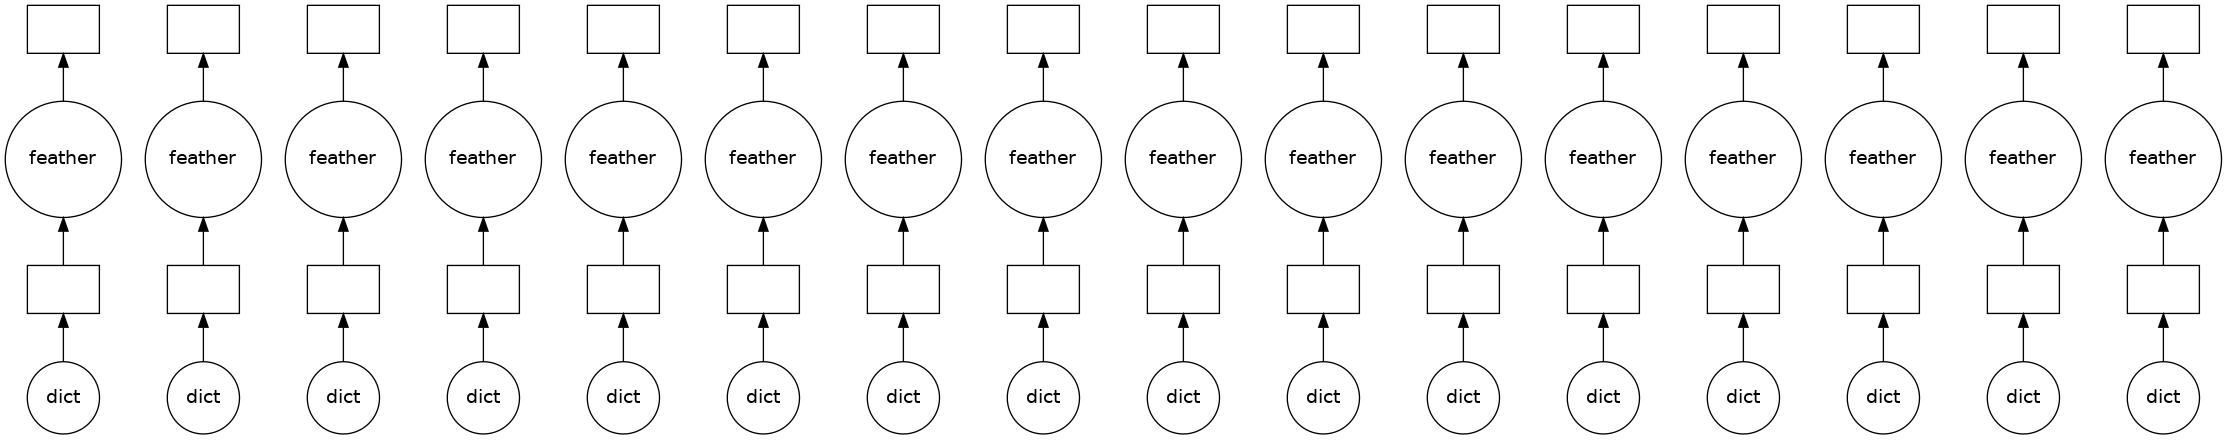

In [12]:
import copy
from astroviper._domain._imaging._fft import _fft_lm_to_uv
from astroviper._domain._imaging._ifft import _ifft_uv_to_lm 
from graphviper.graph_tools.map import map
import dask
import numpy as np
import xarray as xr


def _feather(input_parms):
    display(HTML(dict_to_html(input_parms)))


        
    
    def _compute_w_multiple_beams(xds, uv):
        """xds is the single dish xds"""
        beams = xds["beam"]
        print("beams shape", beams.shape)
        w = np.zeros(xds["sky"].shape)
        bunit = beams.attrs["units"]
        bmaj = beams.sel(beam_param="major")
        # add l and m dims
        bmaj = np.expand_dims(bmaj, -1)
        bmaj = np.expand_dims(bmaj, -1)
        print("bmaj shape", bmaj.shape)
        alpha = bmaj * u.Unit(bunit)
        alpha = alpha.to(u.rad).value
        bmin = beams.sel(beam_param="minor")
        bmin = np.expand_dims(bmin, -1)
        bmin - np.expand_dims(bmin, -1)
        beta = bmin * u.Unit(bunit)
        beta = beta.to(u.rad).value
        bpa = beams.sel(beam_param="pa")
        print("bpa shape", bpa.shape)
        bpa = np.expand_dims(bpa, -1)
        bpa = np.expand_dims(bpa, -1)
        phi = bpa * u.Unit(bunit)
        phi = phi.to(u.rad).value
        
        alpha2 = alpha*alpha
        beta2 = beta*beta
        # u -> uu, v -> vv because we've already used
        # u for astropy.units
        uu, vv = uv
        uu = uu[np.newaxis, np.newaxis, np.newaxis, :, :]
        vv = vv[np.newaxis, np.newaxis, np.newaxis, :, :]
        print("u v shape", uu.shape, vv.shape)
        aterm2 = (uu*np.sin(phi) - vv*np.cos(phi))**2
        print("aterm2, shape",aterm2.shape)
        bterm2 = (uu*np.cos(phi) + vv*np.sin(phi))**2
        print("bterm2 shape", bterm2.shape)
        w = np.exp(
            -np.pi*np.pi/4.0/np.log(2)
            * (
                alpha2*aterm2 + beta2*bterm2
            )
        )
        # w is an np.array
        return w

    


    from xradio.image import load_image
    # if input_parms["input_data"] is None: #Load 
    dtypes = [np.int32, np.int32]
    for i, data_store in enumerate(input_parms["input_data_store"]):
        xds = load_image(
            data_store, 
            block_des=input_parms["data_selection"]["img"]
        )
        fft_plane = (
            xds['sky'].dims.index(input_parms["axes"][0]),
            xds['sky'].dims.index(input_parms["axes"][1])
        )
        # else:
        #   img_xds = input_parms["input_data"]['img'] #In memory
        aperture = _fft_lm_to_uv(xds["sky"], fft_plane)
        dtypes[i] = xds["sky"].dtype
        if i == 0:
            int_ap = aperture
            int_xds = xds
        else:
            sd_ap = aperture
            sd_xds = xds
    mytype = dtypes[0] if dtypes[0] < dtypes[1] else dtypes[1]
    w = (
        input_parms["w"]
        if input_parms["w"]
        else _compute_w_multiple_beams(sd_xds, input_parms["uv"])
    )
    one_minus_w = 1 - w
    s = input_parms["s"]
    beam_ratio = input_parms["beam_ratio"]
    if not beam_ratio:
        if "beam" in int_xds.data_vars:
            # compute area for multiple beams
            int_ba = (
                int_xds["beam"].sel(beam_param="major")
                * int_xds["beam"].sel(beam_param="minor")
            )
        else:
            int_ba = _beam_area_single_beam(int_xds)
        
        if "beam"in sd_xds.data_vars:
            # compute area for multiple beams
            sd_ba = (
                sd_xds["beam"].sel(beam_param="major")
                * sd_xds["beam"].sel(beam_param="minor")
            )
        else:
            sd_ba = _beam_area_single_beam(sd_xds)
        beam_ratio = int_ba/sd_ba
        beam_ratio = np.expand_dims(beam_ratio, -1)
        beam_ratio = np.expand_dims(beam_ratio, -1)

    print("one_minus_w shape", one_minus_w.shape)
    print("int_ap shape", int_ap.shape)
    print("beam ratio shape", beam_ratio.shape)
    print("sd_ap shape", sd_ap.shape)
    print("w shape", w.shape)
    term = (
        (
            one_minus_w * int_ap
            + s * beam_ratio * sd_ap
        )
        / (one_minus_w + s * w)
    )
    feather_npary = _ifft_uv_to_lm(term, fft_plane).astype(mytype)
    feather_xds = copy.deepcopy(int_xds)
    display(feather_xds)
    feather_xrary = xr.DataArray(
        feather_npary, coords=int_xds["sky"].coords,
        dims=int_xds["sky"].dims
    )
    feather_xrary.rename("sky")
    feather_xds["sky"] = feather_xrary
    print("sky shape", feather_xds["sky"].shape)
    return feather_xds  

zn = "int.zarr"
zo = "sd.zarr"
from xradio.image import write_image
import os
# imgs = [int_xds, sd_xds]
if "beam" in int_xds.data_vars:
    zn = "int_mb.zarr"
    if not os.path.exists(zn):
        write_image(int_xds, zn, "zarr")

if "beam" in sd_xds.data_vars:
    zo = "sd_mb_1.zarr"
    if not os.path.exists(zo):
        write_image(sd_xds, zo, "zarr")
    
zarr_names = [zn, zo]
# debug = read_image(zn)
# print("beam shape", debug.beam.shape)

input_parms = {}
input_parms["input_data_store"] = zarr_names
input_parms["axes"] = ('l','m')#(3,4)
# beam_ratio should be computed inside _feather if
# at least one image has multiple beams
input_parms["beam_ratio"] = beam_ratio
input_parms["w"] = w
input_parms["uv"] = uv
input_parms["s"] = 1

graph = map(
    input_data=input_data,
    node_task_data_mapping=node_task_data_mapping,
    node_task=_feather,
    input_parms=input_parms,
    in_memory_compute=False
)

dask.visualize(graph, filename="map_graph")


In [13]:
res = dask.compute(graph)

beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 9.626e+06
  * frequency        (frequency) float64 1.407e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 5.501e+06
  * frequency        (frequency) float64 1.427e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 0.0
  * frequency        (frequency) float64 1.453e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 -8.251e+06
  * frequency        (frequency) float64 1.493e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 6.876e+06
  * frequency        (frequency) float64 1.42e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 1.375e+06
  * frequency        (frequency) float64 1.447e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 8.251e+06
  * frequency        (frequency) float64 1.413e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 -9.626e+06
  * frequency        (frequency) float64 1.5e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 -4.126e+06
  * frequency        (frequency) float64 1.473e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 -5.501e+06
  * frequency        (frequency) float64 1.48e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 2.75e+06
  * frequency        (frequency) float64 1.44e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 -2.75e+06
  * frequency        (frequency) float64 1.467e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 -1.375e+06
  * frequency        (frequency) float64 1.46e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 -6.876e+06
  * frequency        (frequency) float64 1.487e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 1.1e+07
  * frequency        (frequency) float64 1.4e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


beams shape (1, 1, 1, 3)
bmaj shape (1, 1, 1, 1, 1)
bpa shape (1, 1, 1)
u v shape (1, 1, 1, 1024, 1024) (1, 1, 1, 1024, 1024)
aterm2, shape (1, 1, 1, 1024, 1024)
bterm2 shape (1, 1, 1, 1024, 1024)
one_minus_w shape (1, 1, 1, 1024, 1024)
int_ap shape (1, 1, 1, 1024, 1024)
beam ratio shape (1, 1, 1, 1, 1)
sd_ap shape (1, 1, 1, 1024, 1024)
w shape (1, 1, 1, 1024, 1024)


<xarray.Dataset>
Dimensions:          (beam_param: 3, l: 1024, m: 1024, polarization: 1,
                      time: 1, frequency: 1)
Coordinates:
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 4.126e+06
  * frequency        (frequency) float64 1.433e+09
Data variables:
    beam             (time, polarization, frequency, beam_param) float64 0.00...
    sky              (time, polarization, frequency, l, m) float32 0.0008517 ...
Attributes:
    active_mask:      
    description:      
    direction:        {'latpole': {'type': 'quantity', 'units': 'rad', 'value...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

sky shape (1, 1, 1, 1024, 1024)


In [14]:
type(res), type(res[0]),type(res[0][0]), type(res[0][0][0])

(tuple, tuple, list, xarray.core.dataset.Dataset)

In [15]:
len(res), len(res[0]), len(res[0][0])

(1, 2, 16)

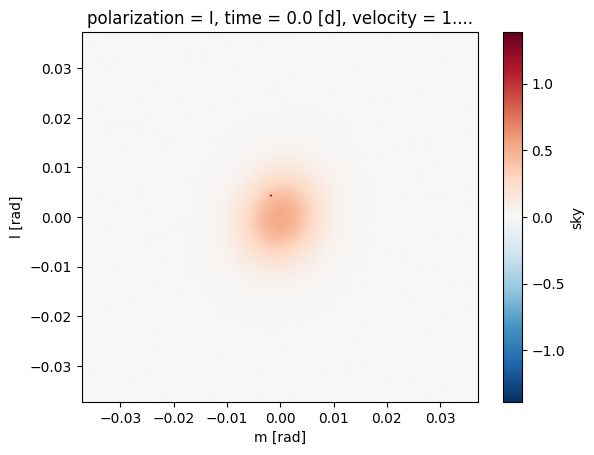

In [16]:
res[0][0][0]["sky"].plot()

In [17]:
final_xds = xr.concat(res[0][0], "frequency")
final_xds
final_xds["sky"].values.dtype

dtype('float32')

In [18]:
import dask.array as da
z = da.array(final_xds["sky"].values)
print(z)
final_xds["sky"] = xr.DataArray(
    z, dims=(
        "time", "polarization", "frequency", "l", "m"
    )
)
import xradio
from xradio import image
image.write_image(final_xds, "feather_test_0.im", "casa")
final_xds["sky"].dtype

dask.array<array, shape=(1, 1, 16, 1024, 1024), dtype=float32, chunksize=(1, 1, 16, 1024, 1024), chunktype=numpy.ndarray>


dtype('float32')

In [ ]:
u.Quantity("0.00031237226207452706rad").to(u.arcsec)

In [ ]:
u.Quantity("-7.27220521664304e-05rad").to("arcsec")